In [16]:
%matplotlib notebook
import numpy as np
import cv2
from plantcv import plantcv as pcv
pcv.params.debug = "plot"

<IPython.core.display.Javascript object>


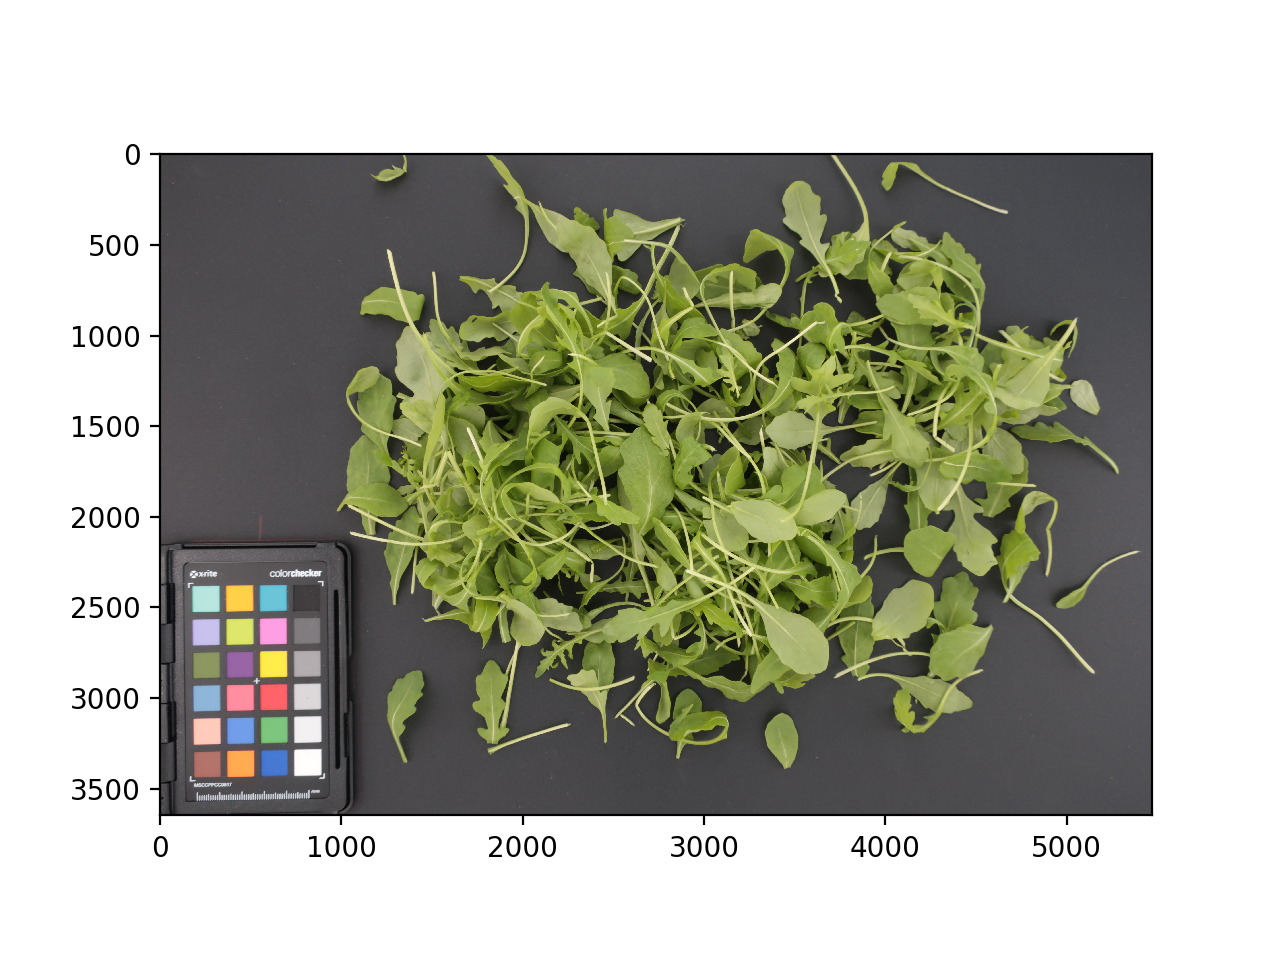

In [2]:
# Open target image
target, targetpath, targetname = pcv.readimage("target.jpg")

<IPython.core.display.Javascript object>


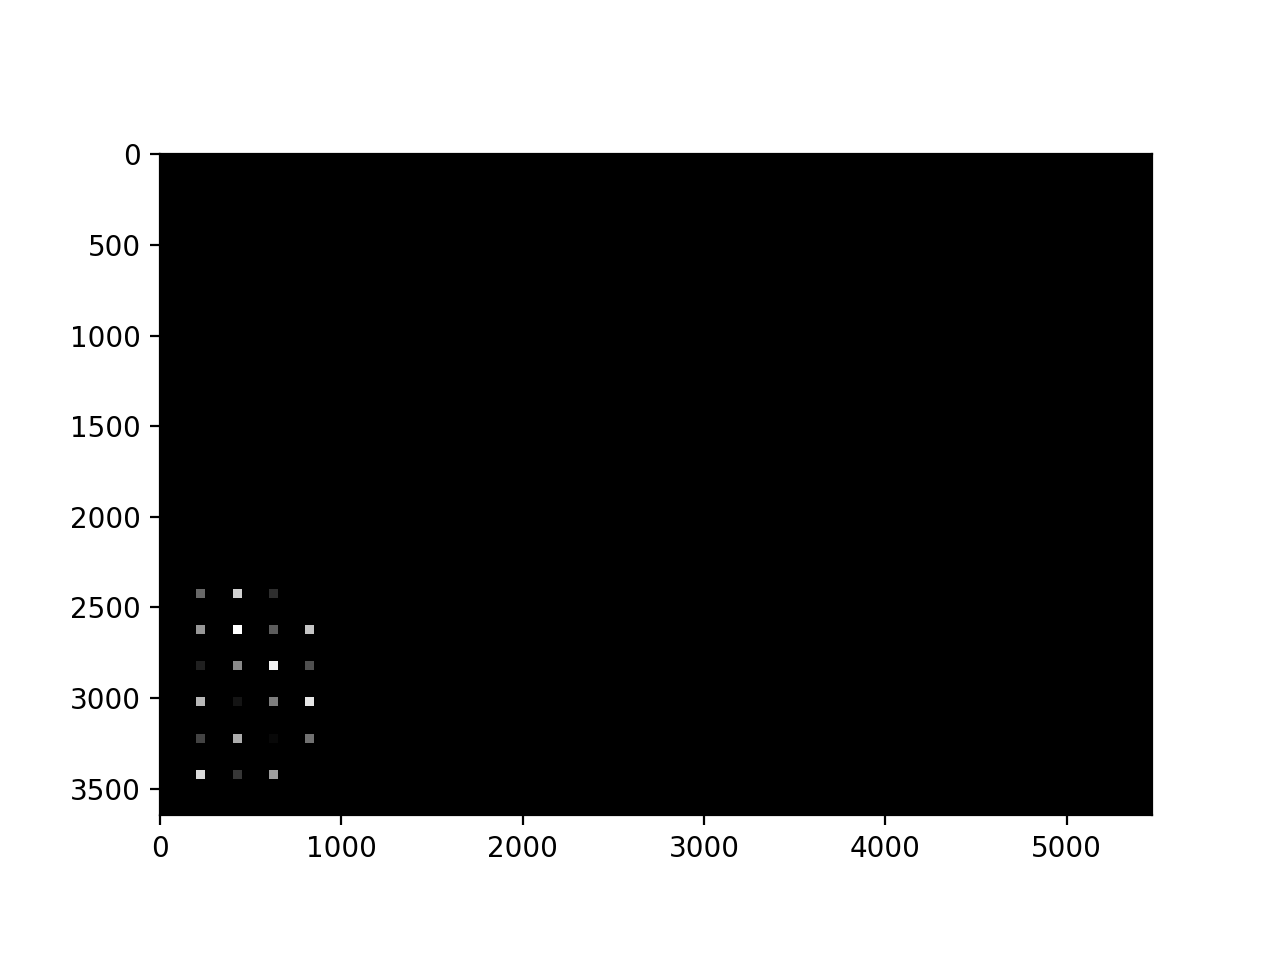

In [9]:
# Open target mask
target_mask, target_mask_path, target_mask_name = pcv.readimage("target_mask.png")

<IPython.core.display.Javascript object>


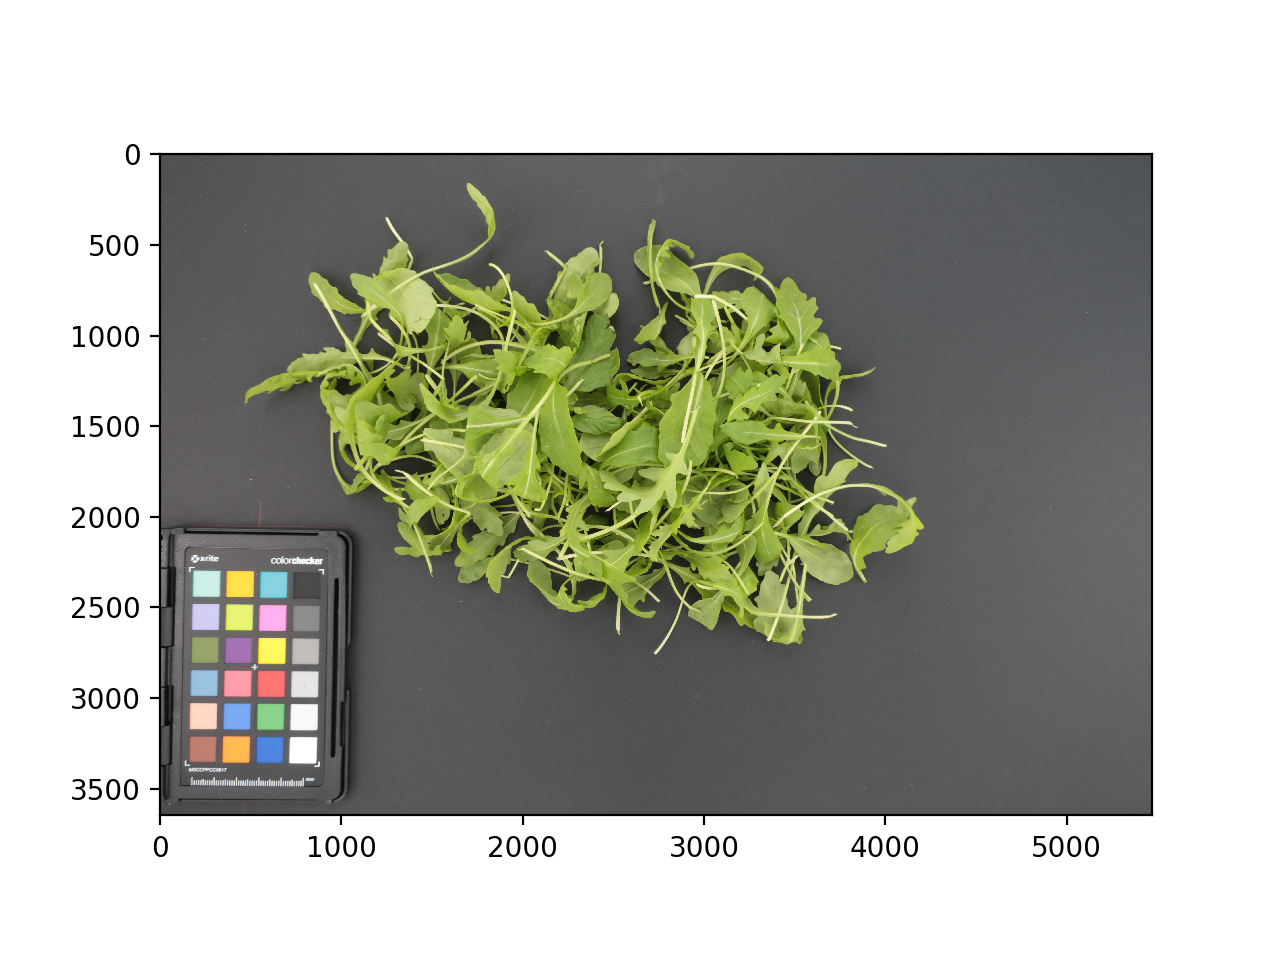

In [7]:
# Open source image
source, sourcepath, sourcename = pcv.readimage("source.jpg")

<IPython.core.display.Javascript object>


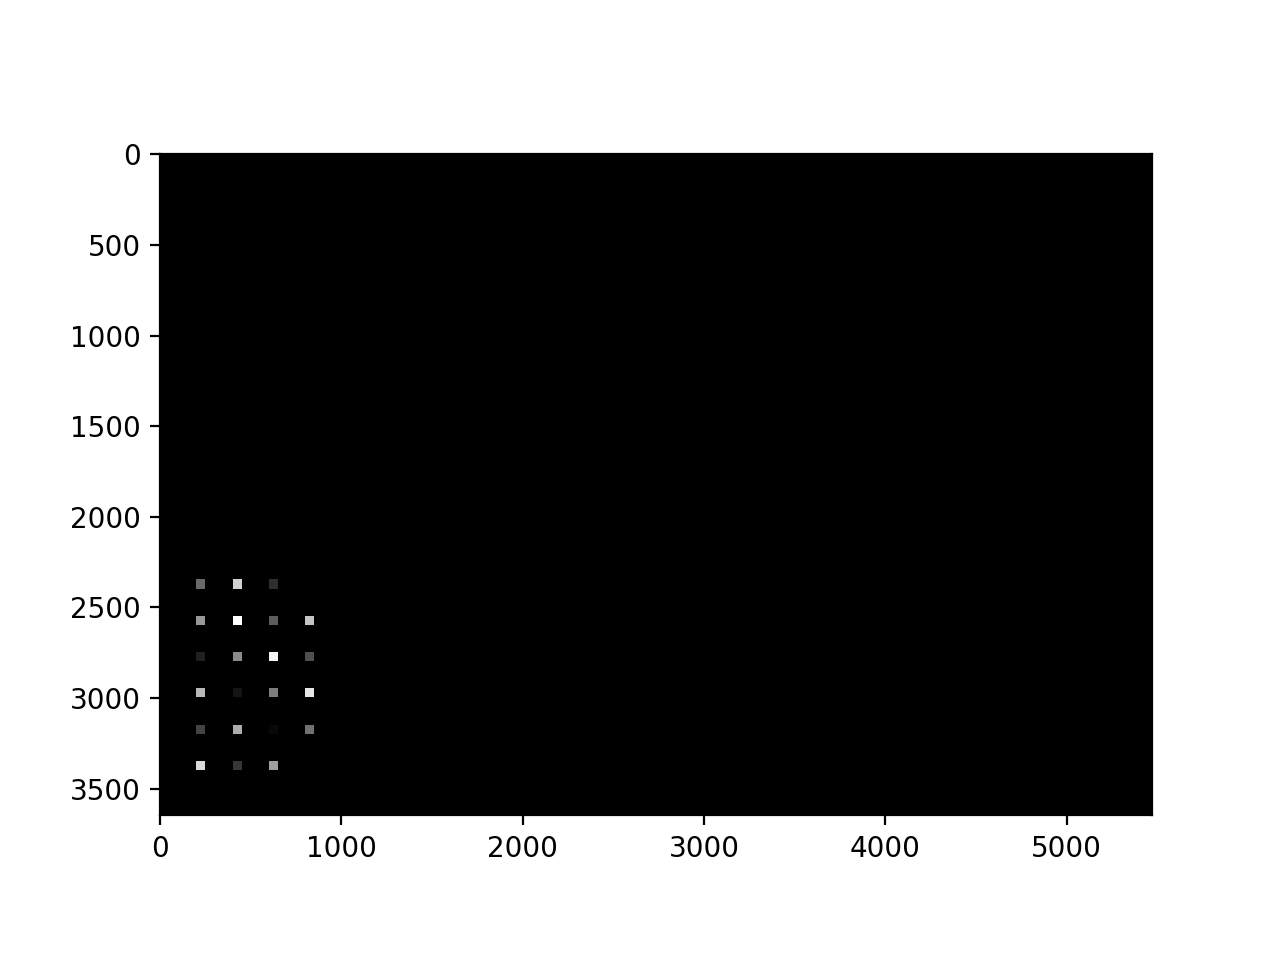

In [11]:
# Open source mask
source_mask, source_mask_path, source_mask_name = pcv.readimage("source_mask.png")

<IPython.core.display.Javascript object>


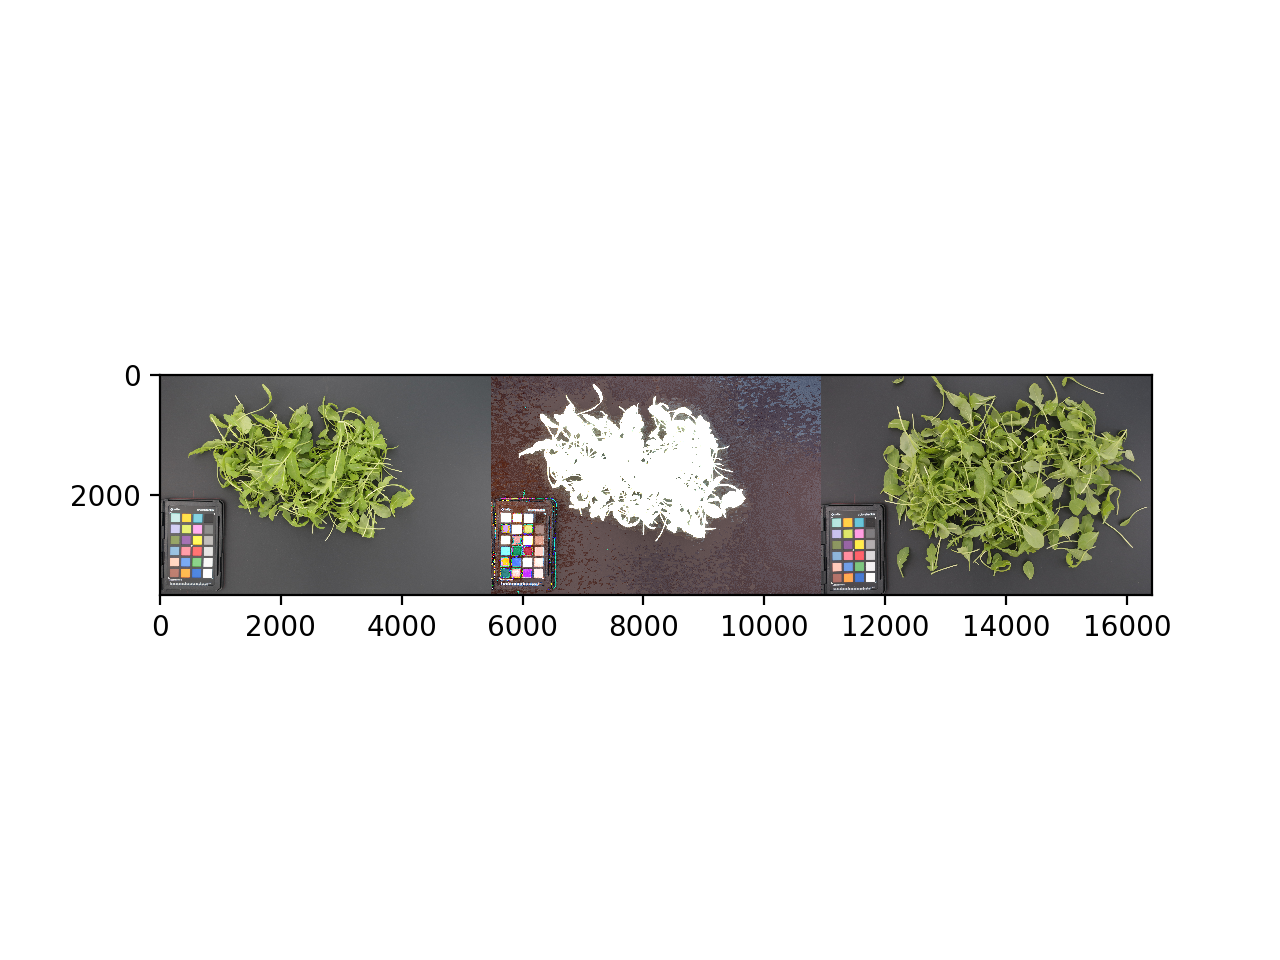

In [13]:
# Color correct source image
target_matrix, source_matrix, transformation_matrix, corrected_img = pcv.transform.correct_color(target_img=target, target_mask=target_mask, source_img=source, source_mask=source_mask, output_directory=".")

Reproduced color correction problem

# Inspect masks

<IPython.core.display.Javascript object>


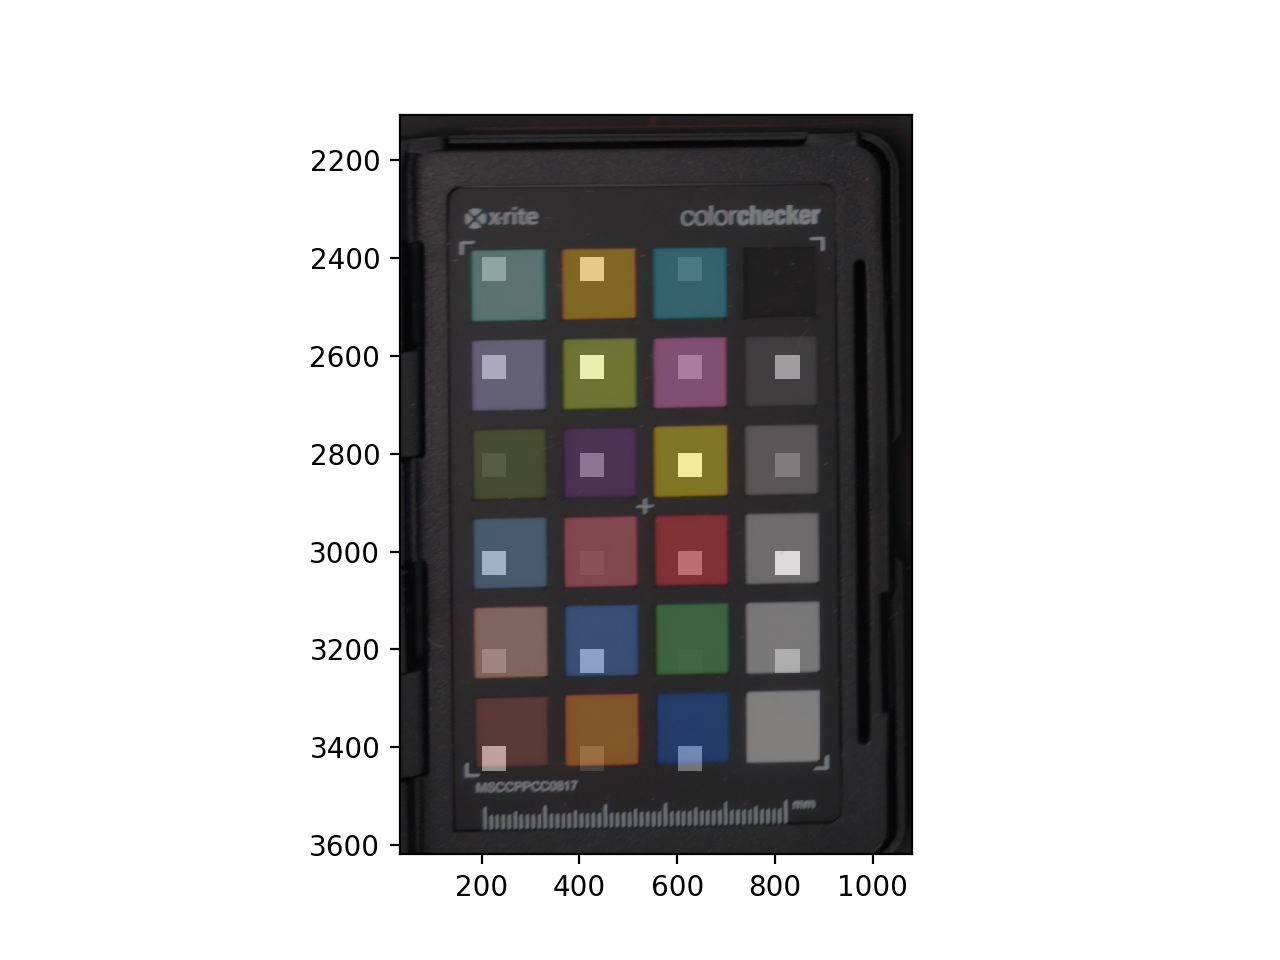

In [20]:
# Plot the target image overlaid with the target mask, zoom in on the color card
pcv.plot_image(cv2.addWeighted(target, 0.5, cv2.merge([target_mask, target_mask, target_mask]), 0.5, 0))

<IPython.core.display.Javascript object>


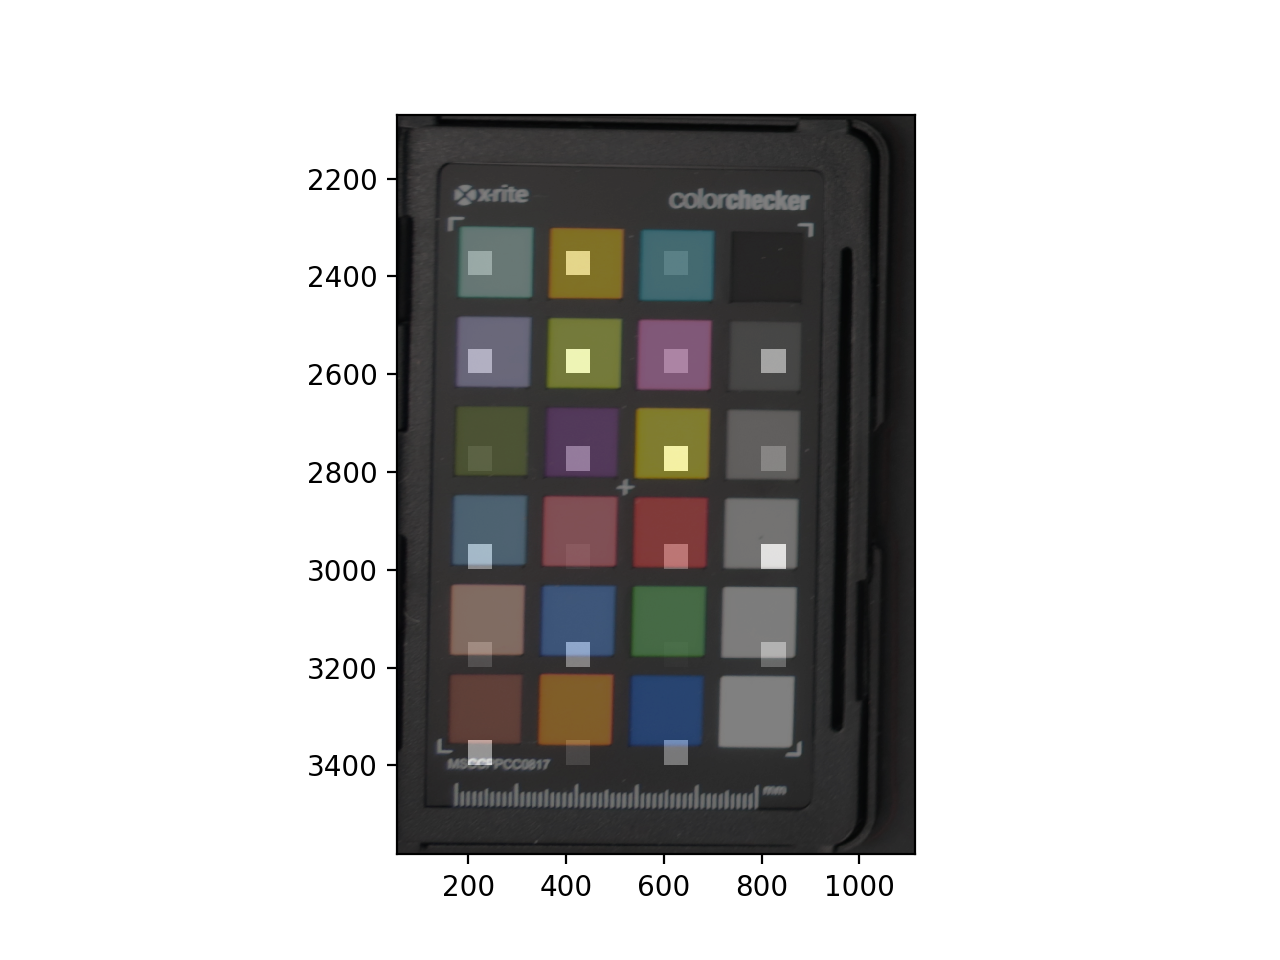

In [21]:
# Plot the source image overlaid with the source mask, zoom in on the color card
pcv.plot_image(cv2.addWeighted(source, 0.5, cv2.merge([source_mask, source_mask, source_mask]), 0.5, 0))

Masks to not appear to line up with the chips

# Semi-automated chip mask code

In [50]:
def create_color_card_mask(rgb_img, chip_dims, start_coord, spacing, nrows, ncols, exclude=[]):
    """Create a labeled mask for color card chips
    Inputs:
    rgb_img        = Input RGB image data containing a color card.
    chip_dims      = Two-element tuple of the chip masks width and height.
    start_coord    = Two-element tuple of the first chip mask starting x and y coordinate.
    spacing        = Two-element tuple of the horizontal and vertical spacing between chip masks.
    nrows          = Number of chip rows.
    ncols          = Number of chip columns.
    exclude        = Optional list of chips to exclude. List in largest to smallest index (e.g. [20, 0])
    
    Returns:
    mask           = Labeled mask of chips
    
    :param rgb_img: numpy.ndarray
    :param chip_dims: tuple
    :param start_coord: tuple
    :param spacing: tuple
    :param nrows: int
    :param ncols: int
    :param exclude: list
    :return mask: numpy.ndarray
    """
    # Initialize chip list
    chips = []
    # Store user debug
    debug = pcv.params.debug
    # Temporarily disable debug
    pcv.params.debug = None
    # Loop over each color card row
    for i in range(0, nrows):
        # The upper left corner is the y starting coordinate + the chip offset * the vertical spacing between chips
        y = start_coord[1] + i * spacing[1]
        # Loop over each column
        for j in range(0, ncols):
            # The upper left corner is the x starting coordinate + the chip offset * the horizontal spacing between chips
            x = start_coord[0] + j * spacing[0]
            # Create a chip ROI
            chips.append(pcv.roi.rectangle(img=rgb_img, x=x, y=y, w=chip_dims[0], h=chip_dims[1]))
    # Remove any excluded chips
    for chip in exclude:
        del chips[chip]
    # Create mask
    mask = np.zeros(shape=np.shape(rgb_img)[:2], dtype = np.uint8())
    # Mask label index
    i = 1
    # Draw labeled chip boxes on the mask
    for chip in chips:
        mask = cv2.drawContours(mask, chip[0], -1, (i*10), -1)
        i += 1
    # Reset debug
    pcv.params.debug = debug
    if pcv.params.debug is not None:
        # Create a copy of the input image for plotting
        canvas = np.copy(rgb_img)
        # Draw chip ROIs on the canvas image
        for chip in chips:
            cv2.drawContours(canvas, chip[0], -1, (255, 255, 0), 5)
        if pcv.params.debug == "print":
            pcv.print_image(img=canvas, filename=os.path.join(pcv.params.debug_outdir, str(pcv.params.device) + "_color_card_mask_rois.png"))
            pcv.print_image(img=mask, filename=os.path.join(pcv.params.debug_outdir, str(pcv.params.device) + "_color_card_mask.png"))
        elif pcv.params.debug == "plot":
            pcv.plot_image(canvas)
    return mask

<IPython.core.display.Javascript object>


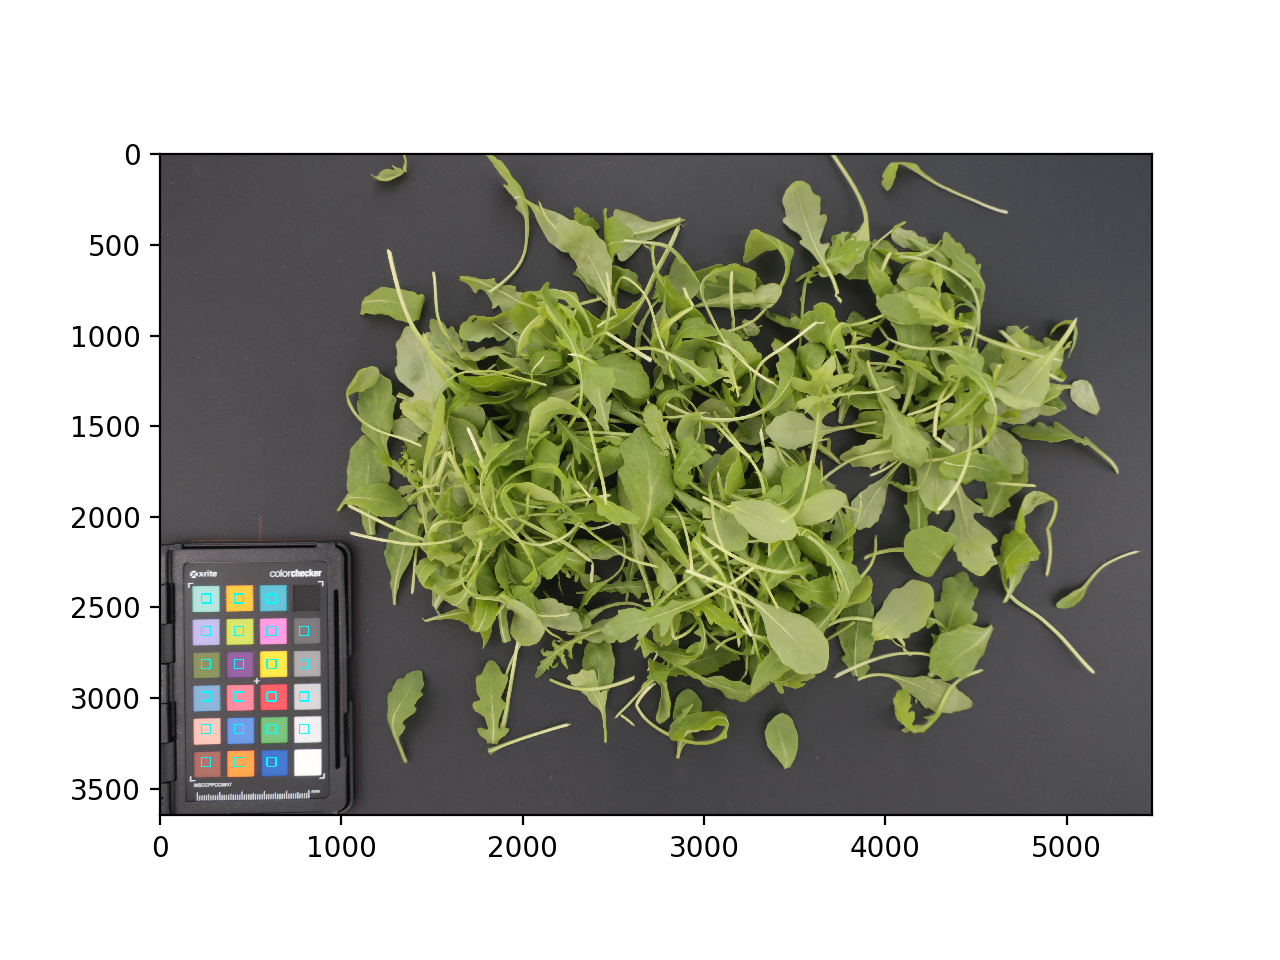

In [58]:
# Create new labeled target color card mask
target_mask = create_color_card_mask(rgb_img=target, chip_dims=(50, 50), start_coord=(230, 2430), spacing=(180, 180), 
                                     ncols=4, nrows=6, exclude=[23, 3])

<IPython.core.display.Javascript object>


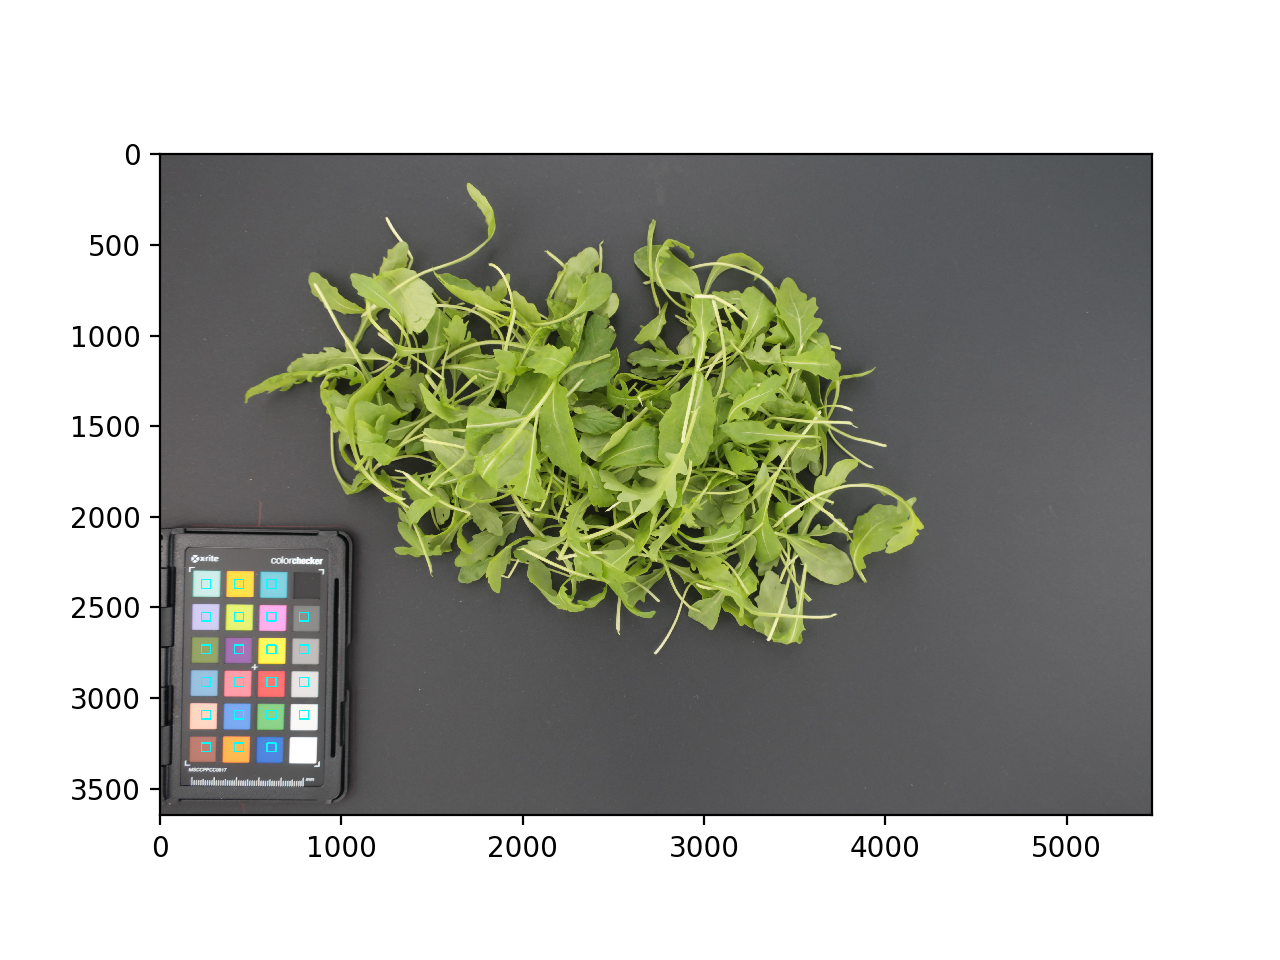

In [57]:
# Create new labeled source color card mask
source_mask = create_color_card_mask(rgb_img=source, chip_dims=(50, 50), start_coord=(230, 2350), spacing=(180, 180), 
                                     ncols=4, nrows=6, exclude=[23, 3])

In [47]:
# Write the color card masks to files
pcv.print_image(img=target_mask, filename="target_color_card_mask.png")
pcv.print_image(img=source_mask, filename="source_color_card_mask.png")

<IPython.core.display.Javascript object>


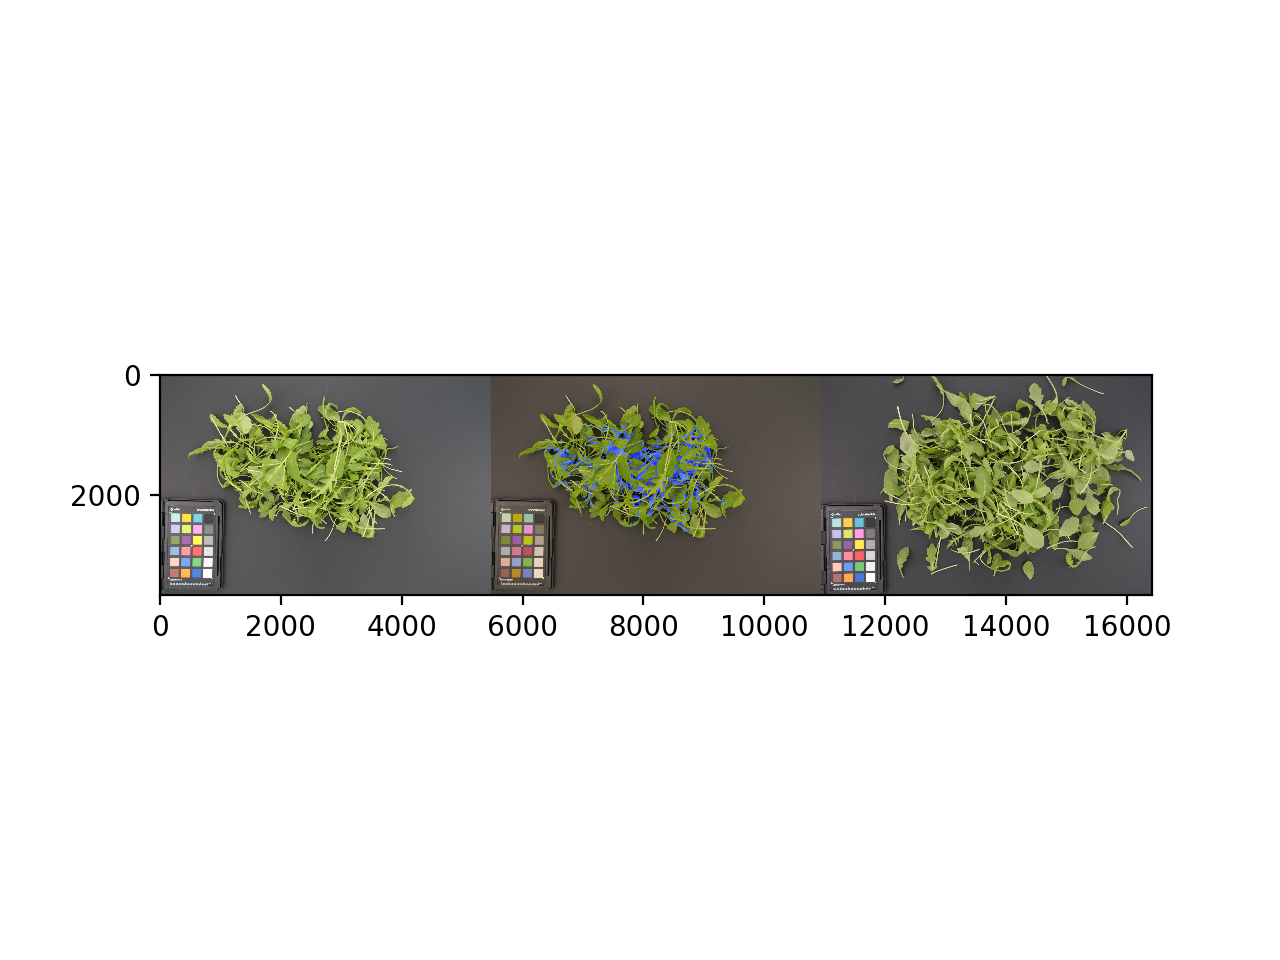

In [55]:
# Retest color correction
target_matrix, source_matrix, transformation_matrix, corrected_img = pcv.transform.correct_color(target_img=target, target_mask=target_mask, source_img=source, source_mask=source_mask, output_directory=".")